In [1]:
import os
import numpy as np
import torch
import csv 

from src.resnet import ResNet18
from src.pca import PCATransformer
from src.draw_figures import *
from src.dataloader import CIFARCustom
from src.umap_transformer import UMAPTransformer

from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
os.makedirs("./data", exist_ok=True) 
os.makedirs("./models", exist_ok=True) 
os.makedirs("./figures", exist_ok=True) 

# filename = "./output.csv"
# with open(filename, mode='w', newline='') as file:
#     writer = csv.writer(file)
    
#     writer.writerow([
#         'target', 
#         'model_f1_score',
#         'model_f1_score_list',
#         'lda_auc',
#         'new_pipline_f1_score', 
#         'new_pipline_f1_score_list'
#     ])




### 1. Подготовка данных:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

target = 9
os.makedirs(f"./output/{target}", exist_ok=True) 

### То, на чем обучаем resnet, строим pca
train_dataset = CIFARCustom(
    root="./data",
    exclude_class=[target],
    train=True, 
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train, val, test = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=2)

### То, на чем делаем холостой (все классы будует неверные) предикт ради feature layer, на чем обучаем и проводим тесты lda
target_dataset = CIFARCustom(
    root="./data",
    exclude_class=[i for i in range(10) if i != target],
    train=True, 
    transform=transform
)

target_train_size = int(0.85 * len(target_dataset))
target_test_size = len(target_dataset) - target_train_size

train_target, test_target = random_split(target_dataset, [target_train_size, target_test_size])

train_target_loader = DataLoader(train_target, batch_size=64, shuffle=True, num_workers=2)
test_target_loader = DataLoader(test_target, batch_size=64, shuffle=True, num_workers=2)

### То, на чем пробуем новый пайплайн
new_pipeline_loader = DataLoader(test+test_target, batch_size=64, shuffle=True, num_workers=2)


In [257]:
len(train_dataset), len(target_dataset), len(train), len(val), len(test), len(train_target), len(test_target)

(45000, 5000, 36000, 6750, 2250, 4250, 750)

### 2. Обучение и inference модели на train наборе данных

In [3]:
resnet = ResNet18(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        learning_rate=0.001,
        num_epochs=5,
        weights=f"./models/resnet18_cifar10_without{target}.pth"
    )

# history = resnet.train()

Loaded weights from ./models/resnet18_cifar10_without9.pth


In [8]:
# plot_loss(history['train_loss'], history['val_loss'], path=f"./output/{target}/train_loss.png")

In [9]:
# plot_accuracy(history['val_accuracy'], path=f"./output/{target}/accuracy.png")

In [10]:
# plot_accuracy(history['val_f1_macro'], "f1_score", path=f"./output/{target}/f1_score.png")

In [11]:
# resnet.save_model('./models/resnet18_cifar10_without{}.pth'.format(target))

### 3. Извлечение признаков модели

In [56]:
test_cifar9_features, test_cifar9_preds, test_cifar9_gt_preds = resnet.extract_features(test_loader)
test_cifar9_iscorrect = test_cifar9_gt_preds == test_cifar9_preds

mask = test_cifar9_gt_preds == test_cifar9_preds
test_cifar9_CR = test_cifar9_features[mask == True]
test_cifar9_WR = test_cifar9_features[mask == False]

test_cifar9_f1_score =  f1_score(test_cifar9_gt_preds, test_cifar9_preds, average="macro")
test_cifar9_f1_score_list = f1_score(test_cifar9_gt_preds, test_cifar9_preds, average=None)

print("f1-мера (глобальные TP и FP): {}, \nПо каждому классу: {}".format(
        test_cifar9_f1_score,
        test_cifar9_f1_score_list
    )
)

f1-мера (глобальные TP и FP): 0.8178893756681016, 
По каждому классу: [0.84410646 0.91774892 0.78225806 0.70932358 0.79777365 0.73197782
 0.86336634 0.83944954 0.875     ]


In [5]:
train_target_features, train_target_preds, train_target_gt_preds = resnet.extract_features(train_target_loader)

mask = train_target_gt_preds == train_target_preds
train_target_CR = train_target_features[mask == True]  
train_target_WR = train_target_features[mask == False] 

len(train_target_CR), len(train_target_WR)

(0, 4250)

#### 3.1 Построение и процецирование в pca пространство:

Финальное количество главных компонент: 22
Объяснённая дисперсия: 0.949


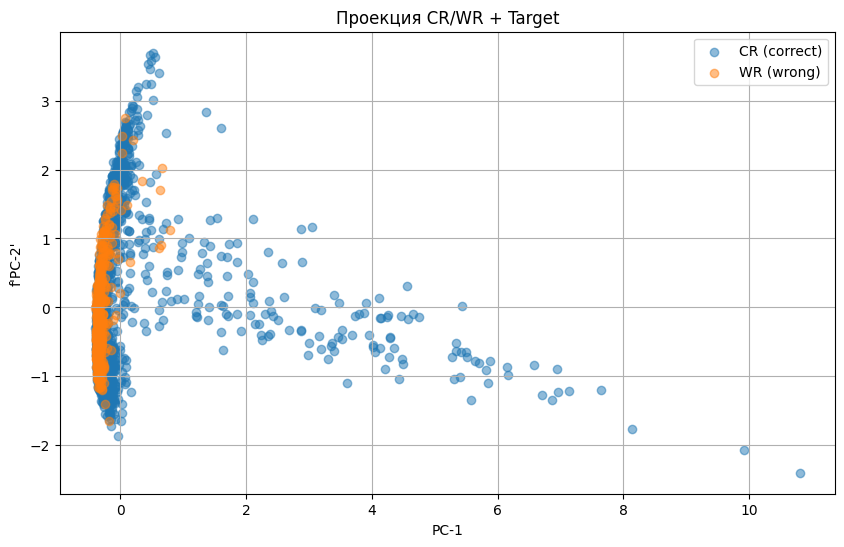

In [6]:
pca = PCATransformer(whiten=True) 
pca.fit(test_cifar9_features)


test_cifar9_CR_p = pca.transform(test_cifar9_CR)
test_cifar9_WR_p = pca.transform(test_cifar9_WR)

                            
plot_projection(test_cifar9_CR_p, test_cifar9_WR_p)

In [7]:
test_cifar9_features_p = pca.transform(test_cifar9_features)

print("Проецирование всех test данных:")
plot_embedding_3d(test_cifar9_features_p, test_cifar9_gt_preds.astype(str))

Проецирование всех test данных:


##### Target выборка

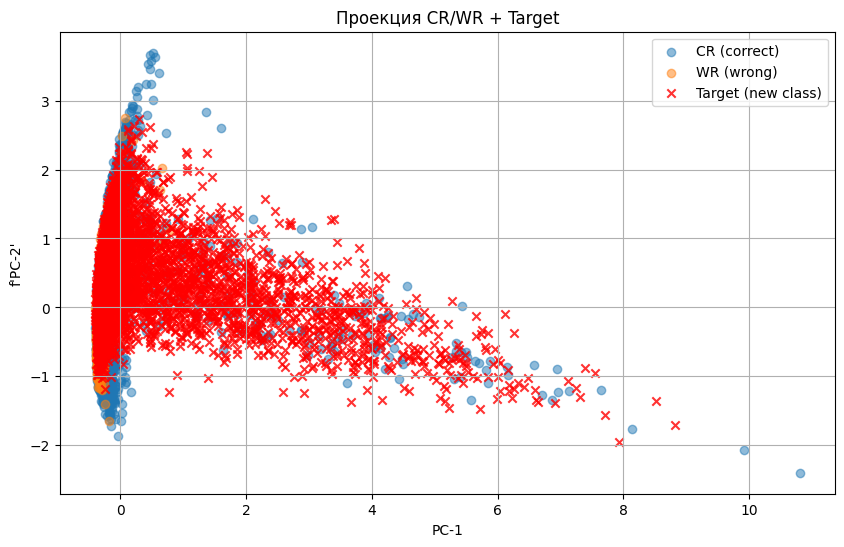

In [8]:
train_target_p = pca.transform(train_target_features)
plot_projection(test_cifar9_CR_p, test_cifar9_WR_p, target_data=train_target_p)

In [9]:
test_cifar9_features_p_with_target_p = np.vstack((test_cifar9_features_p, train_target_p))
test_cifar9_gt_preds_with_target = np.concatenate((test_cifar9_gt_preds, train_target_gt_preds))

print(f"Проецирование всех test данных c target классом ({target}):")
plot_embedding_3d(test_cifar9_features_p_with_target_p, test_cifar9_gt_preds_with_target.astype(str))

Проецирование всех test данных c target классом (9):


#### 3.2 Построение и процецирование в umap пространство:

In [98]:
umap = UMAPTransformer(n_components=3, n_neighbors=5, min_dist=0.1, metric='cosine')
umap.fit(test_cifar9_features)

test_cifar9_CR_u = umap.transform(test_cifar9_CR)
test_cifar9_WR_u = umap.transform(test_cifar9_WR)

/home/minin/workspace/ErrorCorrector/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP обучен: 3 компоненты


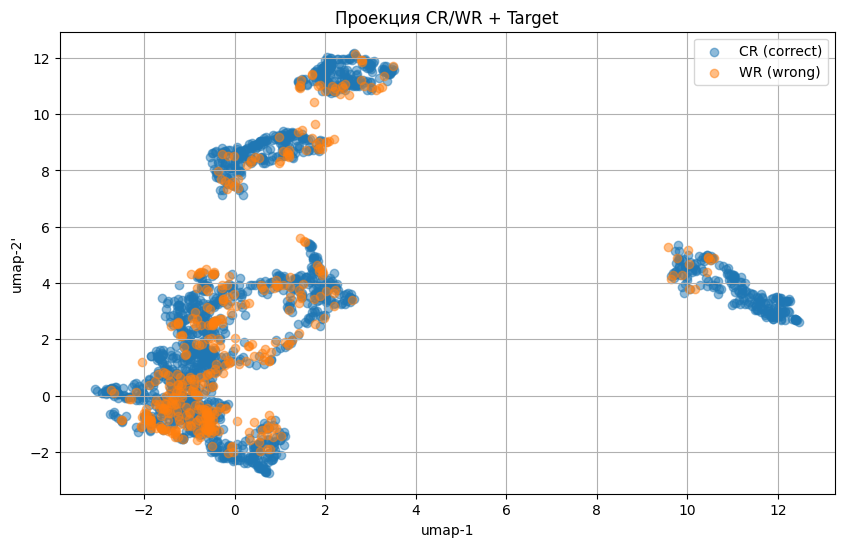

In [99]:
plot_projection(test_cifar9_CR_u, test_cifar9_WR_u, method="umap")

In [100]:
test_cifar9_features_u = umap.transform(test_cifar9_features)
plot_embedding_3d(test_cifar9_features_u, test_cifar9_gt_preds)

##### Target выборка

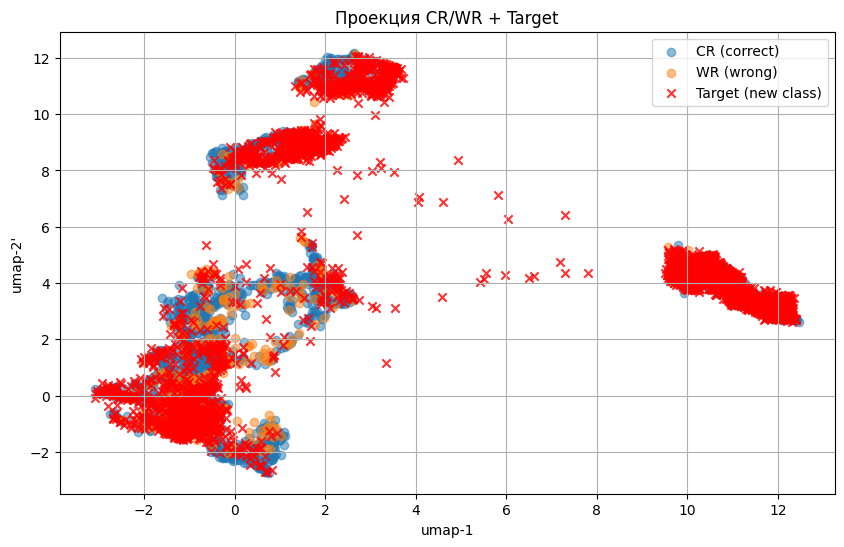

In [101]:
train_target_u = umap.transform(train_target_features)
plot_projection(test_cifar9_CR_u, test_cifar9_WR_u, target_data=train_target_u, method="umap")

In [102]:
test_cifar9_features_u_with_target_u = np.vstack((test_cifar9_features_u, train_target_u))


print(f"Проецирование всех test данных c target классом ({target}):")
plot_embedding_3d(test_cifar9_features_u_with_target_u, test_cifar9_gt_preds_with_target.astype(str))

Проецирование всех test данных c target классом (9):


#### 3.3 Комбинированный методом

In [103]:
umap_comb = UMAPTransformer(n_components=3, n_neighbors=15, min_dist=0.1, metric='cosine')
umap_comb.fit(test_cifar9_features_p)

test_cifar9_CR_pu = umap_comb.transform(test_cifar9_CR_p)
test_cifar9_WR_pu = umap_comb.transform(test_cifar9_WR_p)

/home/minin/workspace/ErrorCorrector/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP обучен: 3 компоненты


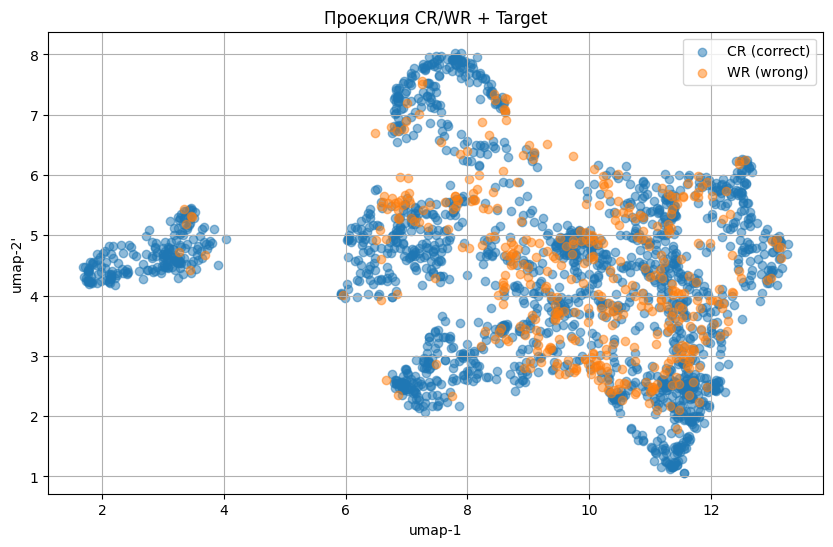

In [104]:
plot_projection(test_cifar9_CR_pu, test_cifar9_WR_pu, method="umap")

In [105]:
test_cifar9_features_pu = umap_comb.transform(test_cifar9_features_p)
plot_embedding_3d(test_cifar9_features_pu, test_cifar9_gt_preds)

##### Target выборка:

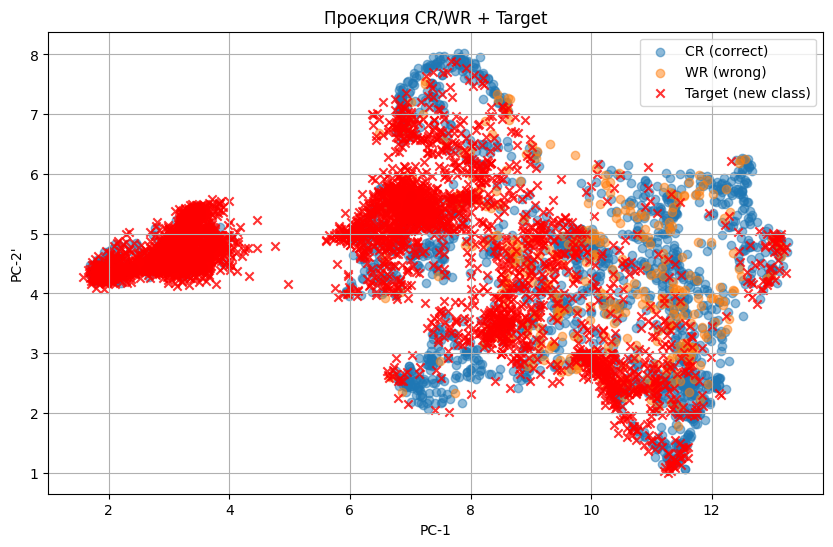

In [106]:
train_target_pu = umap_comb.transform(train_target_p)
plot_projection(test_cifar9_CR_pu, test_cifar9_WR_pu, target_data=train_target_pu)

In [107]:
test_cifar9_features_pu_with_target_pu = np.vstack((test_cifar9_features_pu, train_target_pu))


print(f"Проецирование всех test данных c target классом ({target}):")
plot_embedding_3d(test_cifar9_features_pu_with_target_pu, test_cifar9_gt_preds_with_target.astype(str))

Проецирование всех test данных c target классом (9):


### 4. (Исключительно вариант курсовой) Обучние lda target vs cr + wr

In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#### 4.1 Для PCA:

In [109]:
X_pca = np.vstack((test_cifar9_CR_p, test_cifar9_WR_p, train_target_p))

# 0 = старые классы (CR+WR), 1 = новый unseen класс
y_pca = np.hstack((
    np.zeros(len(test_cifar9_CR_p) + len(test_cifar9_WR_p)),
    np.ones(len(train_target_p))
))

lda_on_pca = LinearDiscriminantAnalysis(n_components=1)
X_pca_lda = lda_on_pca.fit_transform(X_pca, y_pca)

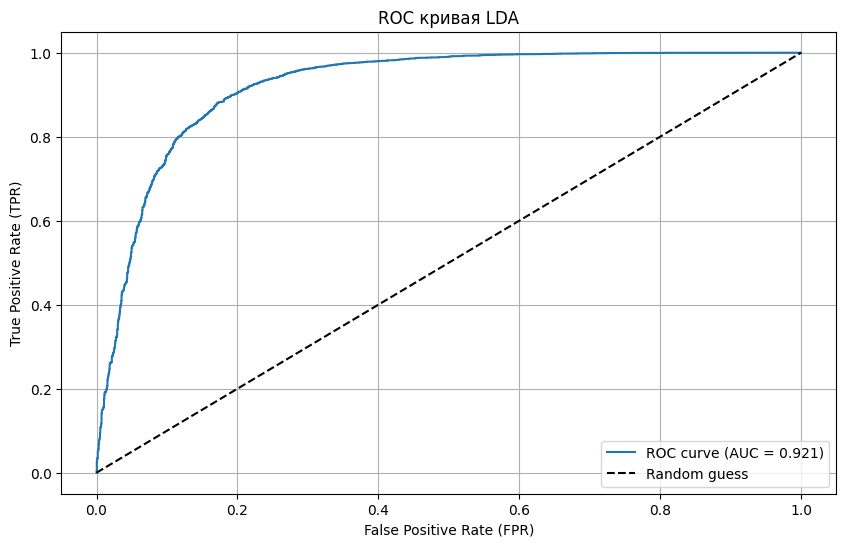

In [110]:
scores = X_pca_lda.ravel()  

lda_pca_auc = plot_roc_auc(scores, y_pca)

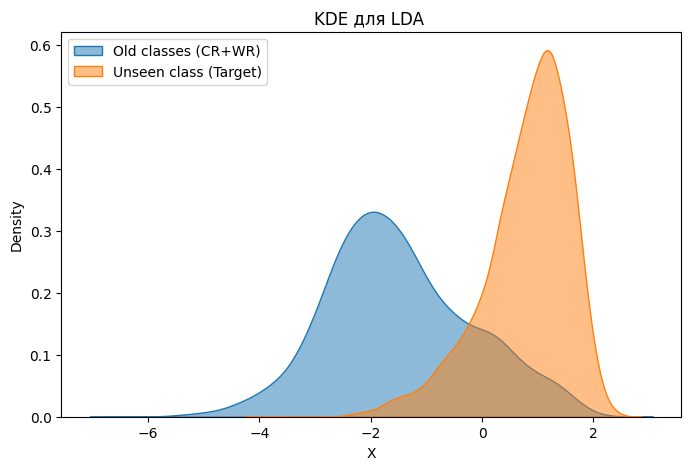

In [111]:
plot_kde(X_pca_lda, y_pca)

#### 4.2 Для UMAP:

In [112]:
X_umap = np.vstack((test_cifar9_CR_u, test_cifar9_WR_u, train_target_u))

# 0 = старые классы (CR+WR), 1 = новый unseen класс
y_umap = np.hstack((
    np.zeros(len(test_cifar9_CR_u) + len(test_cifar9_WR_u)),
    np.ones(len(train_target_u))
))

lda_on_umap = LinearDiscriminantAnalysis(n_components=1)
X_umap_lda = lda_on_umap.fit_transform(X_umap, y_umap)

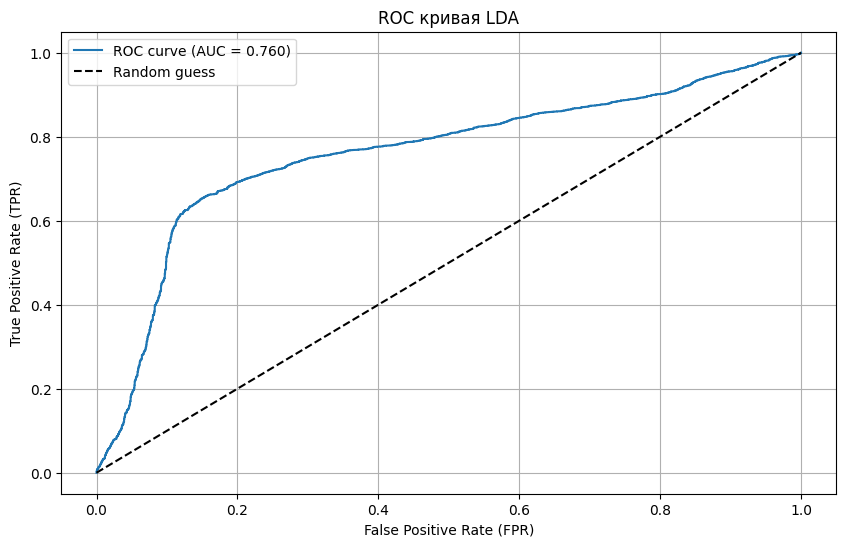

In [113]:
scores = X_umap_lda.ravel()  


lda_umap_auc = plot_roc_auc(scores, y_umap)

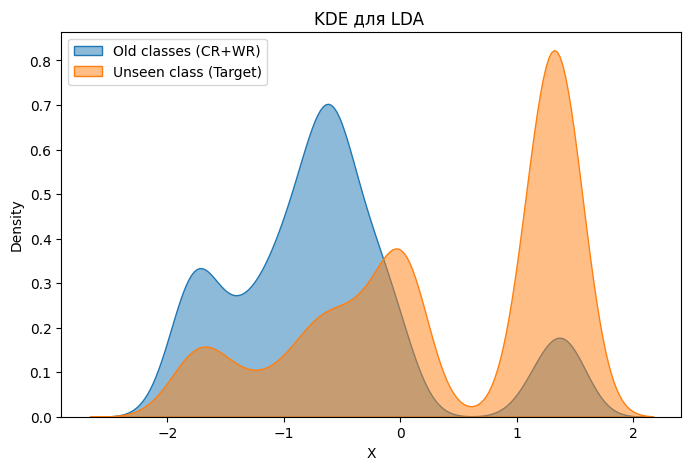

In [114]:
plot_kde(X_umap_lda, y_umap)

### 4.3 Комбинированный:

In [115]:
X_comb = np.vstack((test_cifar9_CR_pu, test_cifar9_WR_pu, train_target_pu))

# 0 = старые классы (CR+WR), 1 = новый unseen класс
y_comb = np.hstack((
    np.zeros(len(test_cifar9_CR_pu) + len(test_cifar9_WR_pu)),
    np.ones(len(train_target_pu))
))

lda_on_comb = LinearDiscriminantAnalysis(n_components=1)
X_comb_lda = lda_on_comb.fit_transform(X_comb, y_comb)

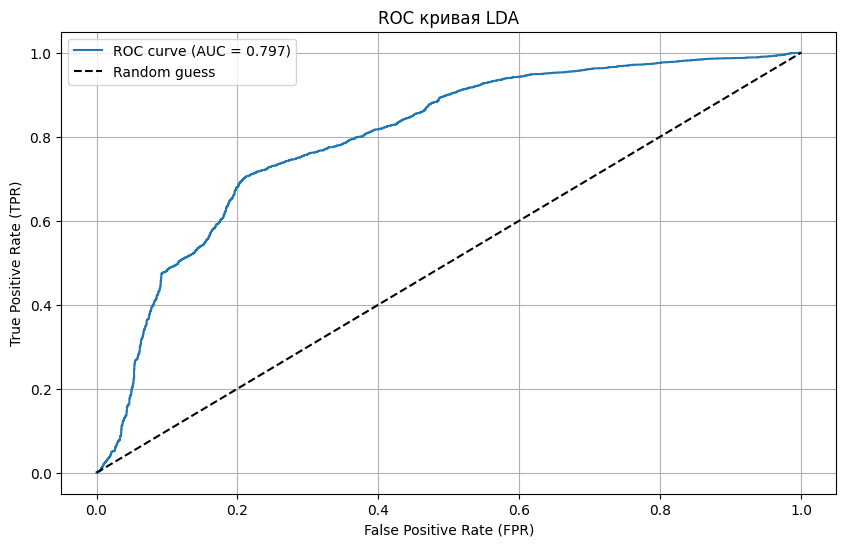

In [116]:
scores = X_comb_lda.ravel()  

lda_comb_auc = plot_roc_auc(scores, y_comb)

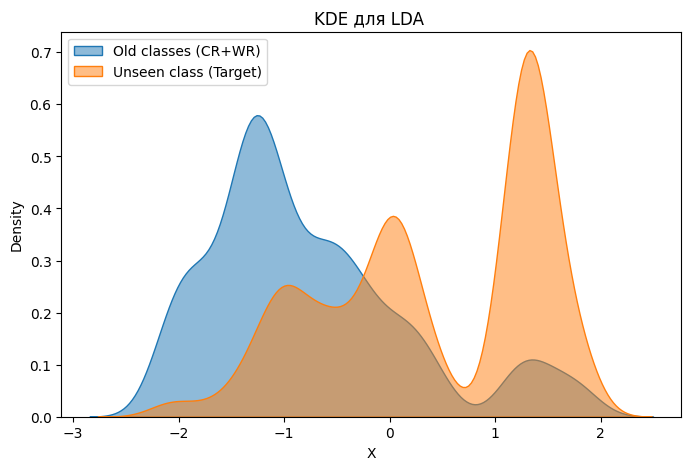

In [117]:
plot_kde(X_comb_lda, y_comb)

###  5. Новый пайплайн

In [118]:
def new_pipeline(loader: DataLoader, thresh: int, lda, proj):
    features, preds, gt_preds = resnet.extract_features(loader)
    features_p = proj.transform(features)


    lda_predict =  np.where(lda.predict_proba(features_p)[:, 1] > thresh, 1, 0)

    print(preds.shape, lda_predict.shape)

    predict = []
    for i in range(lda_predict.shape[0]):
        if lda_predict[i]:
            predict.append(target)
        else:
            predict.append(preds[i])

    return np.array(predict), gt_preds


In [119]:
def print_metric(preds, gt_preds):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    new_pipeline_loader_f1_score_macro = f1_score(preds, gt_preds, average="macro")
    new_pipeline_loader_f1_score_micro = f1_score(preds, gt_preds, average="micro")
    new_pipeline_loader_f1_score_list = f1_score(preds, gt_preds, average=None)
    new_pipeline_loader_acc = accuracy_score(preds, gt_preds)

    print("f1-мера (глобальные TP и FP): {} \nf1-score (усреднее): {}" \
    "\nf1-score (по каждому классу): {} \nacc: {}".format(
        new_pipeline_loader_f1_score_macro,
        new_pipeline_loader_f1_score_micro,
        new_pipeline_loader_f1_score_list,
        new_pipeline_loader_acc
        )
    )

#### 5.1 Для PCA:

In [120]:
preds, gt_preds = new_pipeline(new_pipeline_loader, 0.8, lda_on_pca, pca)
print_metric(preds, gt_preds)

(3000,) (3000,)
f1-мера (глобальные TP и FP): 0.6936756393478423 
f1-score (усреднее): 0.721
f1-score (по каждому классу): [0.75862069 0.11155378 0.75051546 0.67030965 0.78084715 0.70524412
 0.83858268 0.78299776 0.82222222 0.71586287] 
acc: 0.721


### 5.2 Для UMAP:

In [121]:
preds, gt_preds = new_pipeline(new_pipeline_loader, 0.8, lda_on_umap, umap)

print_metric(preds, gt_preds)

(3000,) (3000,)
f1-мера (глобальные TP и FP): 0.6555211131607723 
f1-score (усреднее): 0.662
f1-score (по каждому классу): [0.75684932 0.04361371 0.76435644 0.64344942 0.77617329 0.70588235
 0.81954887 0.73790323 0.76470588 0.54272864] 
acc: 0.662


#### 5.3 Для COMB

In [122]:
preds, gt_preds = new_pipeline(new_pipeline_loader, 0.8, lda_on_comb, umap_comb)

print_metric(preds, gt_preds)

(3000,) (3000,)
f1-мера (глобальные TP и FP): 0.6417355777549592 
f1-score (усреднее): 0.6003333333333334
f1-score (по каждому классу): [0.74740484 0.47113164 0.75806452 0.64119601 0.75324675 0.70967742
 0.77317554 0.72874494 0.76679842 0.06791569] 
acc: 0.6003333333333334


### 6. Это на посмотреть про модели resnet

In [123]:
import pandas as pd

df = pd.read_csv("output/output.csv")
df

,target,model_f1_score,model_f1_score_list,lda_auc,new_pipline_f1_score,new_pipline_f1_score_list
0,1,0.735887,[0.781893 0.67611336 0.58241758 0.68727273 0...,0.920521,0.629972,[0.71428571 0.74311927 0.65191147 0.56934307 0...
1,2,0.743612,[0.78857143 0.80066445 0.63071895 0.69402985 0...,0.839520,0.644540,[0.60089686 0.78547855 0.60223925 0.52436975 0...
2,3,0.771551,[0.7655914 0.8313253 0.69731801 0.696 0...,0.849246,0.659876,[0.73706897 0.8266129 0.61567164 0.63355408 0...
3,4,0.693711,[0.68284229 0.76470588 0.54404145 0.54298643 0...,0.859066,0.621521,[0.62565905 0.77732794 0.32121212 0.44117647 0...
4,5,0.740745,[0.7494824 0.81569966 0.64864865 0.59080963 0...,0.898085,0.647199,[0.73770492 0.81016949 0.5631929 0.02586207 0...
5,6,0.707305,[0.78927203 0.82375479 0.65774379 0.48526077 0...,0.881264,0.620875,[0.77212806 0.80151229 0.47488584 0.21958457 0...
6,7,0.705105,[0.72693032 0.81801802 0.64912281 0.52966102 0...,0.905490,0.623947,[0.72727273 0.80789946 0.61399549 0.43792325 0...
7,8,0.725341,[0.8173258 0.83529412 0.64615385 0.57713249 0...,0.915912,0.640390,[0.33426184 0.66813187 0.62998102 0.53406998 0...
8,9,0.734099,[0.74725275 0.89333333 0.66814159 0.5478424 0...,0.922164,0.651095,[0.6635514 0.26315789 0.65033408 0.53136531 0...
9,0,0.717787,[0.83972912 0.66138614 0.53533191 0.65116279 0...,0.896292,0.649496,[0.69427527 0.82272727 0.47216036 0.51820128 0...
